# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [36]:
import pandas as pd
import numpy as np
import torch
import torchtuples as tt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# No need for KNNImputer directly if your input CSVs are already fully imputed

# Pycox for survival analysis deep learning
from pycox.models import CoxPH
from pycox.models.loss import CoxPHLoss
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt


In [37]:
# Set a random seed for reproducibility
np.random.seed(42)
_ = torch.manual_seed(42)

## Model Selection

Using a Deep Learning approach that extends the Cox Proportional Hazards idea, often called a "Deep Cox Model" or "DeepSurv" style model, which uses a neural network to learn a non-linear relationship between features and the log-hazard ratio.



In [38]:
import os

# Set current working directory
os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")
print(f"Current working directory: {os.getcwd()}")

# Load the datasets
print("\n--- Loading Data ---")
cln_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv")
cln_eval = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv")
maf_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv")
maf_eval = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv")
target_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv")


print("\n--- Initial Data Info ---")
print("cln_df info:")
cln_df.info()
print("\nmaf_df info:")
maf_df.info()
print("\ntarget_df info:")
target_df.info()

# Explicitly ensure OS_YEARS is float and OS_STATUS is integer (0 or 1)
print("\n--- Coercing Target Data Types and Handling NaNs in target_df ---")
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')
target_df['OS_STATUS'] = pd.to_numeric(target_df['OS_STATUS'], errors='coerce').astype('Int64') # Use Int64 for nullable integer first

# Drop any rows where OS_YEARS or OS_STATUS might have become NaN due to coercion (bad data)
original_rows_target = len(target_df)
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(int) # Final conversion to non-nullable int
if len(target_df) < original_rows_target:
    print(f"Warning: Dropped {original_rows_target - len(target_df)} rows from target_df due to uncoercible/missing OS_YEARS or OS_STATUS.")

print("\nFinal target_df info (after type coercion and dropna):")
target_df.info()
print("\nVerifying OS_STATUS data type and values:")
print(target_df['OS_STATUS'].value_counts())
print(f"OS_STATUS dtype: {target_df['OS_STATUS'].dtype}")


print("\n--- Ensuring all clinical and molecular data are clean and typed ---")
for df_name, df in zip(['cln_df', 'maf_df'], [cln_df, maf_df]):
    print(f"\nProcessing {df_name}...")
    for col in df.columns:
        if df[col].isnull().any():
            print(f"  - Column '{col}' in {df_name} has {df[col].isnull().sum()} NaNs.")
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"    - Filled NaNs in numeric column '{col}' with median {median_val}.")
            elif pd.api.types.is_object_dtype(df[col]):
                mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
                df[col] = df[col].fillna(mode_val)
                print(f"    - Filled NaNs in categorical column '{col}' with mode '{mode_val}'.")
            else:
                # Catch-all for other types if they somehow have NaNs
                print(f"    - Warning: Column '{col}' has NaNs and is of type {df[col].dtype}. Filling with a placeholder based on type.")
                df[col] = df[col].fillna(df[col].mean() if pd.api.types.is_float_dtype(df[col]) else 'Missing')
        # Ensure numeric columns are actually numeric after all fills
        if pd.api.types.is_numeric_dtype(df[col]) and not np.issubdtype(df[col].dtype, np.number):
            print(f"  - Warning: Numeric column '{col}' in {df_name} is not a proper numeric subtype. Coercing.")
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].isnull().any():
                 print(f"    - NaNs introduced during coercion in '{col}'. Filling with median.")
                 df[col] = df[col].fillna(df[col].median())

    print(f"Final {df_name} info after cleaning:")
    df.info()
    print(f"NaN count in {df_name} after cleaning:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Current working directory: /workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics

--- Loading Data ---

--- Initial Data Info ---
cln_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3323 non-null   float64
 3   WBC           3323 non-null   float64
 4   ANC           3323 non-null   float64
 5   MONOCYTES     3323 non-null   float64
 6   HB            3323 non-null   float64
 7   PLT           3323 non-null   float64
 8   CYTOGENETICS  3323 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB

maf_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0  

In [39]:
print("\n--- Molecular Data Aggregation ---")
# 1. Aggregate numerical molecular data (VAF, DEPTH) per patient
molecular_numeric_agg = maf_df.groupby('ID')[['VAF', 'DEPTH']].mean().add_suffix('_MEAN').reset_index()

# 2. Create binary presence/absence features for top N genes and effects
top_n_genes = maf_df['GENE'].value_counts().nlargest(50).index.tolist()
top_n_effects = maf_df['EFFECT'].value_counts().nlargest(10).index.tolist()

gene_presence_df = maf_df[maf_df['GENE'].isin(top_n_genes)][['ID', 'GENE']].drop_duplicates()
effect_presence_df = maf_df[maf_df['EFFECT'].isin(top_n_effects)][['ID', 'EFFECT']].drop_duplicates()

gene_features = pd.crosstab(gene_presence_df['ID'], gene_presence_df['GENE']).add_prefix('GENE_')
effect_features = pd.crosstab(effect_presence_df['ID'], effect_presence_df['EFFECT']).add_prefix('EFFECT_')

# Combine all molecular features into one DataFrame
molecular_features_df = pd.merge(
    molecular_numeric_agg,
    gene_features.reset_index(),
    on='ID',
    how='outer'
).merge(
    effect_features.reset_index(),
    on='ID',
    how='outer'
).fillna(0) # Fill NaN from outer joins with 0, meaning no mutation/feature if missing

print("\nAggregated Molecular Features Head:")
print(molecular_features_df.head())
print("\nAggregated Molecular Features Info:")
molecular_features_df.info()
print(f"NaN count in molecular_features_df after aggregation:\n{molecular_features_df.isnull().sum()[molecular_features_df.isnull().sum() > 0]}")



--- Molecular Data Aggregation ---

Aggregated Molecular Features Head:
        ID  VAF_MEAN  DEPTH_MEAN  GENE_ARID2  GENE_ASXL1  GENE_ASXL2  \
0  P100000    0.3013       834.5         0.0         0.0         0.0   
1  P100001    0.2595       536.0         0.0         0.0         0.0   
2  P100002    0.3970       398.5         0.0         0.0         0.0   
3  P100004    0.4691      1296.0         0.0         0.0         0.0   
4  P100006    0.1693       591.4         0.0         0.0         0.0   

   GENE_BCOR  GENE_BCORL1  GENE_BRCC3  GENE_CBL  ...  \
0        0.0          0.0         0.0       1.0  ...   
1        0.0          0.0         0.0       0.0  ...   
2        0.0          0.0         0.0       0.0  ...   
3        0.0          0.0         0.0       0.0  ...   
4        0.0          0.0         0.0       0.0  ...   

   EFFECT_2KB_upstream_variant  EFFECT_ITD  EFFECT_PTD  \
0                          0.0         0.0         0.0   
1                          0.0         0.

In [40]:
print("\n--- Merging All Data ---")
# Merge clinical, molecular features, and target data
full_data = pd.merge(cln_df, molecular_features_df, on='ID', how='left')
# Use inner join with target_df to ensure we only train on patients with valid outcome data
full_data = pd.merge(full_data, target_df, on='ID', how='inner')

# Drop the 'ID' column as it's no longer needed as a feature for the model input
full_data = full_data.drop(columns=['ID'])

print("\n--- Final Checks on 'full_data' before feature separation ---")
print("full_data info before final NaN fill:")
full_data.info()

# Final check for any NaNs that might have been introduced by the 'left' merge for molecular data
# These would be patients from cln_df who had no molecular data and thus NaN for molecular_features_df columns
for col in full_data.columns:
    if col not in ['OS_YEARS', 'OS_STATUS'] and full_data[col].isnull().any():
        print(f"  - Column '{col}' in full_data has {full_data[col].isnull().sum()} NaNs after merge.")
        if pd.api.types.is_numeric_dtype(full_data[col]):
            median_val = full_data[col].median()
            full_data[col] = full_data[col].fillna(median_val)
            print(f"    - Filled NaNs in numeric feature '{col}' with median {median_val}.")
        elif pd.api.types.is_object_dtype(full_data[col]):
            mode_val = full_data[col].mode()[0] if not full_data[col].mode().empty else 'Unknown'
            full_data[col] = full_data[col].fillna(mode_val)
            print(f"    - Filled NaNs in categorical feature '{col}' with mode '{mode_val}'.")
        else:
             print(f"    - Warning: Column '{col}' has NaNs and is of type {full_data[col].dtype}. Filling with a placeholder based on type.")
             full_data[col] = full_data[col].fillna(full_data[col].mean() if pd.api.types.is_float_dtype(full_data[col]) else 'Missing')

print("\nfull_data info after final NaN fill:")
full_data.info()
print(f"NaN count in full_data after all merges and fills:\n{full_data.isnull().sum()[full_data.isnull().sum() > 0]}")


# Define features (X) and target (duration, event)
duration = full_data['OS_YEARS'].values.astype('float32')
event = full_data['OS_STATUS'].values.astype('int32')

features_df = full_data.drop(columns=['OS_YEARS', 'OS_STATUS'])

print("\nCombined Features DataFrame Head (before final preprocessing):")
print(features_df.head())
print(f"Total features after initial merge: {features_df.shape[1]}")
print(f"Shape of duration: {duration.shape}")
print(f"Shape of event: {event.shape}")


--- Merging All Data ---

--- Final Checks on 'full_data' before feature separation ---
full_data info before final NaN fill:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CENTER                         3323 non-null   object 
 1   BM_BLAST                       3323 non-null   float64
 2   WBC                            3323 non-null   float64
 3   ANC                            3323 non-null   float64
 4   MONOCYTES                      3323 non-null   float64
 5   HB                             3323 non-null   float64
 6   PLT                            3323 non-null   float64
 7   CYTOGENETICS                   3323 non-null   object 
 8   VAF_MEAN                       3026 non-null   float64
 9   DEPTH_MEAN                     3026 non-null   float64
 10  GENE_ARID2                     3026 non-n

## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [41]:
print("\n--- Feature Preprocessing Pipeline ---")
# Identify numerical and categorical columns for preprocessing
numerical_cols = features_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = features_df.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns identified: {numerical_cols}")
print(f"Categorical columns identified: {categorical_cols}")

# Double-check that numerical_cols truly contain only numeric types and categorical_cols only object/string types
# This helps catch if a column was misidentified or has mixed types
for col in numerical_cols:
    if not pd.api.types.is_numeric_dtype(features_df[col]):
        print(f"CRITICAL WARNING: Column '{col}' in numerical_cols is not purely numeric (dtype: {features_df[col].dtype}). Removing from numerical_cols.")
        numerical_cols.remove(col)
        categorical_cols.append(col) # Try to treat it as categorical

for col in categorical_cols:
    # Check if a categorical column might actually be numeric (e.g., loaded as object but contains only numbers)
    # This can happen if numbers are mixed with NaNs in a column that was object, then NaNs filled, but column remains object.
    if pd.api.types.is_numeric_dtype(features_df[col]):
        print(f"CRITICAL WARNING: Column '{col}' in categorical_cols is actually numeric (dtype: {features_df[col].dtype}). Moving to numerical_cols.")
        categorical_cols.remove(col)
        numerical_cols.append(col)

# Re-verify and rebuild ColumnTransformer with corrected lists
print(f"Final numerical columns for ColumnTransformer: {numerical_cols}")
print(f"Final categorical columns for ColumnTransformer: {categorical_cols}")


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(features_df)

# Convert to dense array if OneHotEncoder creates a sparse matrix
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

print(f"\nShape of X_processed after ColumnTransformer: {X_processed.shape}")
print(f"Data type of X_processed after ColumnTransformer: {X_processed.dtype}")

# Critical check: Ensure no NaNs and correct dtype before converting to Torch tensor
if np.isnan(X_processed).any():
    print("CRITICAL ERROR: NaN values detected in X_processed after ColumnTransformer. Inspect 'features_df' and ColumnTransformer setup.")
    # For deep debugging, save the problematic array:
    pd.DataFrame(X_processed).to_csv('debug_X_processed_with_nans_post_ct.csv', index=False)
    raise ValueError("NaN values still detected in processed features (X_processed).")

if not np.issubdtype(X_processed.dtype, np.number):
    print(f"CRITICAL ERROR: X_processed is not a numerical type ({X_processed.dtype}). It should be float or int.")
    raise ValueError("Processed features (X_processed) are not numerical.")

# Convert to PyTorch tensors with consistent dtypes
X_tensor = torch.from_numpy(X_processed.astype(np.float32)).float()
duration_tensor = torch.from_numpy(duration.astype(np.float32)).float()
event_tensor = torch.from_numpy(event.astype(np.float32)).float()  # Changed to float32

print(f"\nShape of processed features (X_tensor): {X_tensor.shape}")
print(f"Data type of X_tensor: {X_tensor.dtype}")
print(f"Data type of duration_tensor: {duration_tensor.dtype}")
print(f"Data type of event_tensor: {event_tensor.dtype}")

# Verify tensor properties
print(f"\nTensor validation:")
print(f"X_tensor - Min: {X_tensor.min().item():.4f}, Max: {X_tensor.max().item():.4f}, Has NaN: {torch.isnan(X_tensor).any()}")
print(f"duration_tensor - Min: {duration_tensor.min().item():.4f}, Max: {duration_tensor.max().item():.4f}, Has NaN: {torch.isnan(duration_tensor).any()}")
print(f"event_tensor - Min: {event_tensor.min().item():.4f}, Max: {event_tensor.max().item():.4f}, Has NaN: {torch.isnan(event_tensor).any()}")



--- Feature Preprocessing Pipeline ---
Numerical columns identified: ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'VAF_MEAN', 'DEPTH_MEAN', 'GENE_ARID2', 'GENE_ASXL1', 'GENE_ASXL2', 'GENE_BCOR', 'GENE_BCORL1', 'GENE_BRCC3', 'GENE_CBL', 'GENE_CEBPA', 'GENE_CSNK1A1', 'GENE_CTCF', 'GENE_CUX1', 'GENE_DDX41', 'GENE_DNMT3A', 'GENE_EP300', 'GENE_ETNK1', 'GENE_ETV6', 'GENE_EZH2', 'GENE_FLT3', 'GENE_GATA2', 'GENE_GNAS', 'GENE_GNB1', 'GENE_IDH1', 'GENE_IDH2', 'GENE_JAK2', 'GENE_KMT2C', 'GENE_KMT2D', 'GENE_KRAS', 'GENE_MLL', 'GENE_MPL', 'GENE_NF1', 'GENE_NFE2', 'GENE_NPM1', 'GENE_NRAS', 'GENE_PHF6', 'GENE_PPM1D', 'GENE_PRPF8', 'GENE_PTPN11', 'GENE_RUNX1', 'GENE_SETBP1', 'GENE_SF3B1', 'GENE_SH2B3', 'GENE_SRSF2', 'GENE_STAG2', 'GENE_TET2', 'GENE_TP53', 'GENE_U2AF1', 'GENE_U2AF2', 'GENE_WT1', 'GENE_ZBTB33', 'GENE_ZRSR2', 'EFFECT_2KB_upstream_variant', 'EFFECT_ITD', 'EFFECT_PTD', 'EFFECT_frameshift_variant', 'EFFECT_inframe_codon_gain', 'EFFECT_inframe_codon_loss', 'EFFECT_initiator_codon_ch

In [42]:
print("\n--- Splitting Data ---")
X_train, X_test, duration_train, duration_test, event_train, event_test = train_test_split(
    X_tensor, duration_tensor, event_tensor, test_size=0.2, random_state=42, stratify=event_tensor.numpy()
)

# Crucial check: Ensure all split tensors are valid and of correct types for torchtuples
for tensor_name, tensor_var in zip(['X_train', 'duration_train', 'event_train', 'X_test', 'duration_test', 'event_test'],
                                   [X_train, duration_train, event_train, X_test, duration_test, event_test]):
    print(f"  - {tensor_name}: Shape={tensor_var.shape}, Dtype={tensor_var.dtype}, Has NaNs={torch.isnan(tensor_var).any()}")

# Convert to tt.tuplefy format correctly - this is crucial for pycox
print("\n--- Creating torchtuples datasets ---")
train_data = (X_train, (duration_train, event_train))
test_data = (X_test, (duration_test, event_test))

# Verify the tuple structure
print(f"Train data structure: X shape {train_data[0].shape}, duration shape {train_data[1][0].shape}, event shape {train_data[1][1].shape}")
print(f"Test data structure: X shape {test_data[0].shape}, duration shape {test_data[1][0].shape}, event shape {test_data[1][1].shape}")

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")


--- Splitting Data ---
  - X_train: Shape=torch.Size([2658, 1285]), Dtype=torch.float32, Has NaNs=False
  - duration_train: Shape=torch.Size([2658]), Dtype=torch.float32, Has NaNs=False
  - event_train: Shape=torch.Size([2658]), Dtype=torch.float32, Has NaNs=False
  - X_test: Shape=torch.Size([665, 1285]), Dtype=torch.float32, Has NaNs=False
  - duration_test: Shape=torch.Size([665]), Dtype=torch.float32, Has NaNs=False
  - event_test: Shape=torch.Size([665]), Dtype=torch.float32, Has NaNs=False

--- Creating torchtuples datasets ---
Train data structure: X shape torch.Size([2658, 1285]), duration shape torch.Size([2658]), event shape torch.Size([2658])
Test data structure: X shape torch.Size([665, 1285]), duration shape torch.Size([665]), event shape torch.Size([665])
Training set size: 2658 samples
Test set size: 665 samples


In [43]:
# in_features = X_train.shape[1]

# class MLP(torch.nn.Module):
#     def __init__(self, in_features, num_nodes, out_features):
#         super().__init__()
#         self.net = torch.nn.Sequential(
#             torch.nn.Linear(in_features, num_nodes[0]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2),
#             torch.nn.Linear(num_nodes[0], num_nodes[1]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2),
#             torch.nn.Linear(num_nodes[1], out_features)
#         )

#     def forward(self, input):
#         return self.net(input)

# num_nodes = [128, 64]
# out_features = 1

# net = MLP(in_features, num_nodes, out_features)
# model = CoxPH(net, tt.optim.Adam(lr=0.01))

# print("\nDeep Learning Model (MLP) and CoxPH wrapper initialized.")
# print(net)

in_features = X_train.shape[1]

class MLP(torch.nn.Module):
    def __init__(self, in_features, num_nodes, out_features):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_features, num_nodes[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4), # Increased dropout
            torch.nn.Linear(num_nodes[0], num_nodes[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4), # Increased dropout
            torch.nn.Linear(num_nodes[1], out_features)
        )

    def forward(self, input):
        return self.net(input)

num_nodes = [128, 64]
out_features = 1

# Instantiate the network
net = MLP(in_features, num_nodes, out_features)

# Define an optimizer with a lower learning rate and weight decay
optimizer = tt.optim.Adam(lr=0.001, weight_decay=1e-4)

# Re-initialize the model with the new optimizer
model = CoxPH(net, optimizer)

print("\nDeep Learning Model (MLP) and CoxPH wrapper initialized with new optimizer.")
print(net)
print("\nOptimizer details:")
print(model.optimizer)


Deep Learning Model (MLP) and CoxPH wrapper initialized with new optimizer.
MLP(
  (net): Sequential(
    (0): Linear(in_features=1285, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

Optimizer details:



Training Deep Learning CoxPH model for up to 600 epochs...
500:	[0s / 0s],		train_loss: 4.3121,	val_loss: 5.2179
501:	[0s / 0s],		train_loss: 4.3144,	val_loss: 5.2192
502:	[0s / 0s],		train_loss: 4.2876,	val_loss: 5.2198
503:	[0s / 0s],		train_loss: 4.3077,	val_loss: 5.2220
504:	[0s / 0s],		train_loss: 4.2396,	val_loss: 5.2263
505:	[0s / 0s],		train_loss: 4.2325,	val_loss: 5.2350
506:	[0s / 0s],		train_loss: 4.2418,	val_loss: 5.2462
507:	[0s / 0s],		train_loss: 4.2132,	val_loss: 5.2493
508:	[0s / 0s],		train_loss: 4.1923,	val_loss: 5.2591
509:	[0s / 0s],		train_loss: 4.1897,	val_loss: 5.2567
510:	[0s / 0s],		train_loss: 4.1595,	val_loss: 5.2655
511:	[0s / 0s],		train_loss: 4.1374,	val_loss: 5.2680
512:	[0s / 0s],		train_loss: 4.1006,	val_loss: 5.2793
513:	[0s / 0s],		train_loss: 4.1015,	val_loss: 5.2924
514:	[0s / 0s],		train_loss: 4.0737,	val_loss: 5.2970
515:	[0s / 0s],		train_loss: 4.0283,	val_loss: 5.3112
516:	[0s / 0s],		train_loss: 4.0139,	val_loss: 5.3355
517:	[0s / 0s],		train

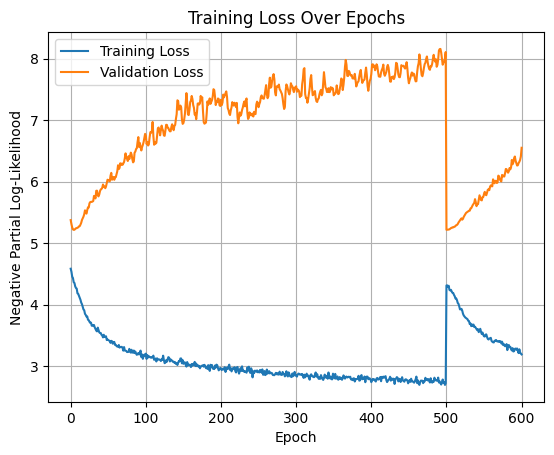


Model training complete.


In [51]:
batch_size = 256
epochs = 600

# Adjust learning rate and add validation split for better monitoring
print(f"\nTraining Deep Learning CoxPH model for up to {epochs} epochs...")

try:
    # Create validation split from training data
    val_size = int(0.2 * len(X_train))
    train_size = len(X_train) - val_size
    
    # Split training data
    X_train_split = X_train[:train_size]
    X_val_split = X_train[train_size:]
    duration_train_split = duration_train[:train_size]
    duration_val_split = duration_train[train_size:]
    event_train_split = event_train[:train_size]
    event_val_split = event_train[train_size:]
    
    # Create data tuples
    train_split = (X_train_split, (duration_train_split, event_train_split))
    val_split = (X_val_split, (duration_val_split, event_val_split))
    
    # Training with validation monitoring
    callbacks = [tt.callbacks.EarlyStopping(patience=100)]  # Increased patience
    
    log = model.fit(train_split[0], train_split[1], batch_size, epochs, 
                   callbacks, verbose=True, val_data=val_split)
    
    # Convert to pandas DataFrame to access training history
    log_df = log.to_pandas()
    
    print(f"\nTraining completed after {len(log_df)} epochs")
    print(f"Final training loss: {log_df['train_loss'].iloc[-1]:.4f}")
    if 'val_loss' in log_df.columns:
        print(f"Final validation loss: {log_df['val_loss'].iloc[-1]:.4f}")
    
    print("\nPlotting training history...")
    _ = log.plot()
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Negative Partial Log-Likelihood')
    plt.legend(['Training Loss', 'Validation Loss'] if 'val_loss' in log_df.columns else ['Training Loss'])
    plt.grid(True)
    plt.show()
    
    print("\nModel training complete.")
    
except Exception as e:
    print(f"Training failed with error: {e}")
    print("Debugging information:")
    print(f"X_train type: {type(train_data[0])}, shape: {train_data[0].shape}, dtype: {train_data[0].dtype}")
    print(f"Target tuple type: {type(train_data[1])}")
    print(f"Duration type: {type(train_data[1][0])}, shape: {train_data[1][0].shape}, dtype: {train_data[1][0].dtype}")
    print(f"Event type: {type(train_data[1][1])}, shape: {train_data[1][1].shape}, dtype: {train_data[1][1].dtype}")
    raise



## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [50]:
print("\n--- Model Evaluation ---")

# Check if model was trained successfully
if hasattr(model, 'net') and model.net is not None:
    try:
        print("Computing baseline hazards using the full training dataset...")
        # CRITICAL FIX: Pass the full training data to compute baseline hazards accurately.
        _ = model.compute_baseline_hazards(X_train, (duration_train, event_train))
        print("Baseline hazards computed successfully.")
        
        print("Generating survival predictions on the test set...")
        # Ensure X_test is on the correct device and format
        if torch.cuda.is_available():
            X_test_eval = X_test.cuda()
        else:
            X_test_eval = X_test
            
        surv_test = model.predict_surv_df(X_test_eval)
        print(f"Survival predictions shape: {surv_test.shape}")

        # Convert tensors to numpy for evaluation
        duration_test_np = duration_test.numpy()
        event_test_np = event_test.numpy()
        
        print("Computing evaluation metrics...")
        ev = EvalSurv(surv_test.T, duration_test_np, event_test_np, censor_surv='km')

        # Compute various metrics
        c_index = ev.concordance_td()
        print(f"\nTime-dependent Concordance Index (C-index) on test set: {c_index:.4f}")
        
        # Integrated Brier Score
        try:
            time_grid = np.linspace(duration_test_np.min(), duration_test_np.max(), 100)
            ibs = ev.integrated_brier_score(time_grid)
            print(f"Integrated Brier Score: {ibs:.4f}")
        except Exception as ibs_error:
            print(f"Could not compute Integrated Brier Score: {ibs_error}")

        # Plot survival curves
        print("\nPlotting predicted survival curves for the first 5 test patients...")
        plt.figure(figsize=(12, 8))
        
        n_patients_to_plot = min(5, surv_test.shape[1])
        for i in range(n_patients_to_plot):
            plt.plot(surv_test.index, surv_test.iloc[:, i], 
                     label=f'Patient {i+1} (Event: {int(event_test_np[i])}, Time: {duration_test_np[i]:.2f})')
        
        plt.title('Predicted Survival Curves for First 5 Test Patients')
        plt.xlabel('Time (Years)')
        plt.ylabel('Survival Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.show()

        # Additional diagnostic plot: Risk scores distribution
        print("\nGenerating risk score analysis...")
        risk_scores = model.predict(X_test_eval).flatten() # Flatten to ensure 1D array
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(risk_scores, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Risk Scores')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        risk_event_0 = risk_scores[event_test_np == 0]
        risk_event_1 = risk_scores[event_test_np == 1]
        
        plt.hist(risk_event_0, bins=20, alpha=0.7, label='Censored (Event=0)', color='blue')
        plt.hist(risk_event_1, bins=20, alpha=0.7, label='Event Occurred (Event=1)', color='red')
        plt.title('Risk Scores by Event Status')
        plt.xlabel('Risk Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nModel Performance Summary:")
        print(f"- C-index: {c_index:.4f} (higher is better, 0.5 = random, 1.0 = perfect)")
        print(f"- Number of test samples: {len(X_test)}")
        print(f"- Events in test set: {int(event_test_np.sum())} ({event_test_np.mean()*100:.1f}%)")
        print(f"- Risk score range: [{risk_scores.min():.3f}, {risk_scores.max():.3f}]")
        
        # Interpretation guide
        if c_index >= 0.7:
            print("- Model shows good discriminative ability")
        elif c_index >= 0.6:
            print("- Model shows moderate discriminative ability")
        else:
            print("- Model shows poor discriminative ability (consider model improvements)")

        print("\nDeep Learning Survival Model training and evaluation complete.")
        
    except Exception as e:
        print(f"Evaluation failed with detailed error: {e}")
        import traceback
        traceback.print_exc()

else:
    print("ERROR: Model was not trained successfully. Cannot proceed with evaluation.")
    print("Please check the training cell for errors.")# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")



--- Model Evaluation ---
Computing baseline hazards using the full training dataset...
Baseline hazards computed successfully.
Generating survival predictions on the test set...
Survival predictions shape: (1458, 665)
Computing evaluation metrics...
Evaluation failed with detailed error: 


Traceback (most recent call last):
  File "/tmp/ipykernel_46247/1415071003.py", line 29, in <module>
    c_index = ev.concordance_td()
              ^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/site-packages/pycox/evaluation/eval_surv.py", line 190, in concordance_td
    return concordance_td(self.durations, self.events, self.surv.values,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.python/current/lib/python3.12/site-packages/pycox/evaluation/concordance.py", line 93, in concordance_td
    assert durations.shape[0] == surv.shape[1] == surv_idx.shape[0] == events.shape[0]
AssertionError
